In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 227
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 10000 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Negative', 'Positive']

In [5]:
len(dataset)

157

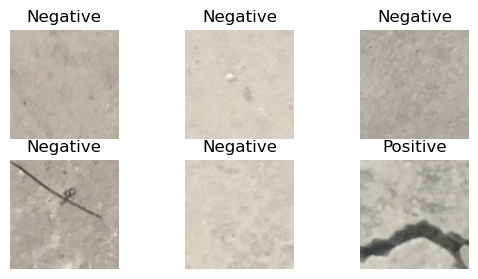

In [6]:
for image_batch, label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(dataset)*train_size

125.60000000000001

In [8]:
train_ds = dataset.take(40)
len(train_ds)

40

In [9]:
test_ds = dataset.skip(40)
len(test_ds)

117

In [10]:
val_size = 0.1
len(dataset)*val_size

15.700000000000001

In [11]:
val_ds = test_ds.take(5)
len(val_ds)

5

In [12]:
test_ds = test_ds.skip(5)
len(test_ds)

112

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)

    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

125

In [16]:
len(val_ds)

15

In [17]:
len(test_ds)

17

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 227, 227, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 225, 225, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 112, 112, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 110, 110, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 55, 55, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 53, 53, 64)         

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5
125/125 [==============================] - 205s 2s/step - loss: 0.3067 - accuracy: 0.8729 - val_loss: 0.1249 - val_accuracy: 0.9604
Epoch 2/5
125/125 [==============================] - 244s 2s/step - loss: 0.0852 - accuracy: 0.9711 - val_loss: 0.0921 - val_accuracy: 0.9646
Epoch 3/5
125/125 [==============================] - 239s 2s/step - loss: 0.0670 - accuracy: 0.9764 - val_loss: 0.0986 - val_accuracy: 0.9667
Epoch 4/5
125/125 [==============================] - 244s 2s/step - loss: 0.0708 - accuracy: 0.9781 - val_loss: 0.0539 - val_accuracy: 0.9812
Epoch 5/5
125/125 [==============================] - 242s 2s/step - loss: 0.0515 - accuracy: 0.9839 - val_loss: 0.0572 - val_accuracy: 0.9823


In [26]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 6s 371ms/step - loss: 0.0463 - accuracy: 0.9856


In [28]:
acc =  history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

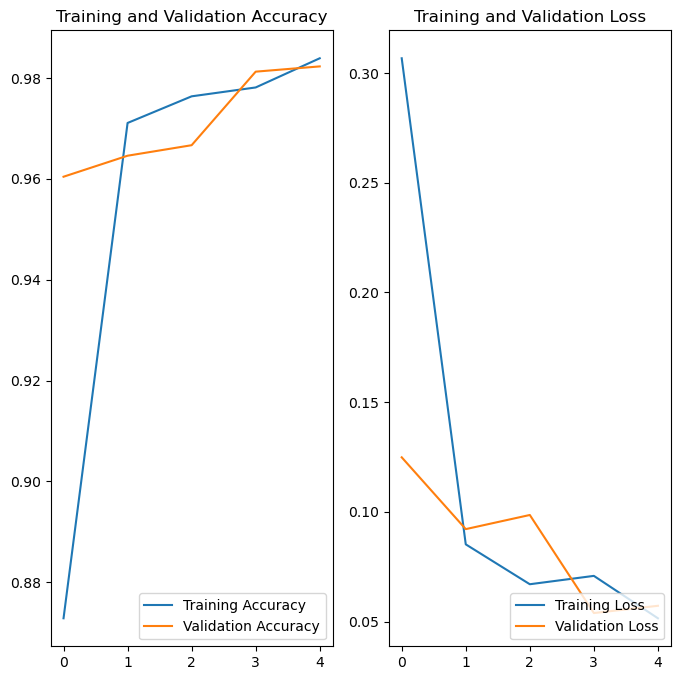

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label: Positive
2/2 [==============================] - 1s 267ms/step
Predicted Label: Positive


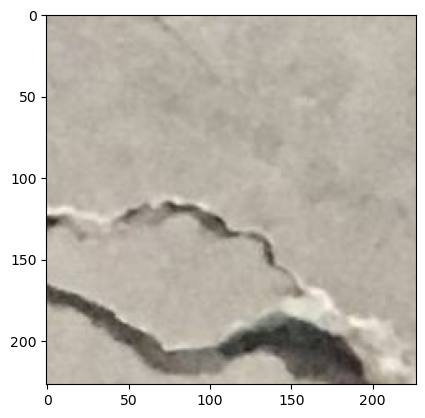

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    print('Actual Label:', class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print('Predicted Label:', class_names[np.argmax(batch_prediction[0])])

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 49ms/step


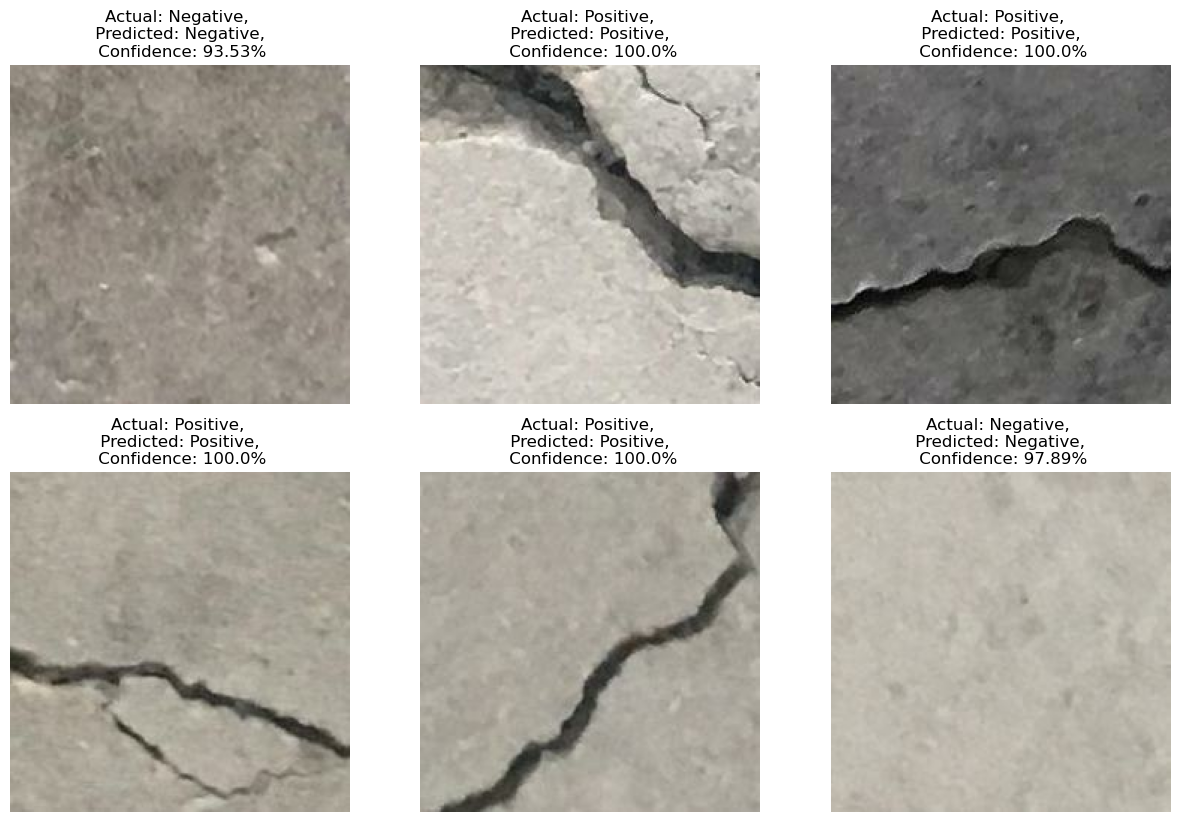

In [32]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
model.save(f"models/")

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


In [34]:
model.save('model.h5')